In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create database engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.prepare(autoload_with = engine, reflect = True)


C:\Users\jhaug\AppData\Local\Temp\ipykernel_31852\1520280675.py:6: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(autoload_with = engine, reflect = True)
C:\Users\jhaug\AppData\Local\Temp\ipykernel_31852\1520280675.py:6: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with = engine, reflect = True)
C:\Users\jhaug\AppData\Local\Temp\ipykernel_31852\1520280675.py:6: SAWarning: This declarative base already 

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
### 3 - 02 SQLAlchemy, Sqlite, and Dates

######### Need to determine which table has dates for below
from sqlalchemy import inspect

inspector = inspect(engine)
inspector.get_table_names()

# Get a list of column names and types
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
# columns


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
### 3 - 02 SQLAlchemy, Sqlite, and Dates

# Get a list of column names and types
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
######### From above, Measurement table has the dates
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

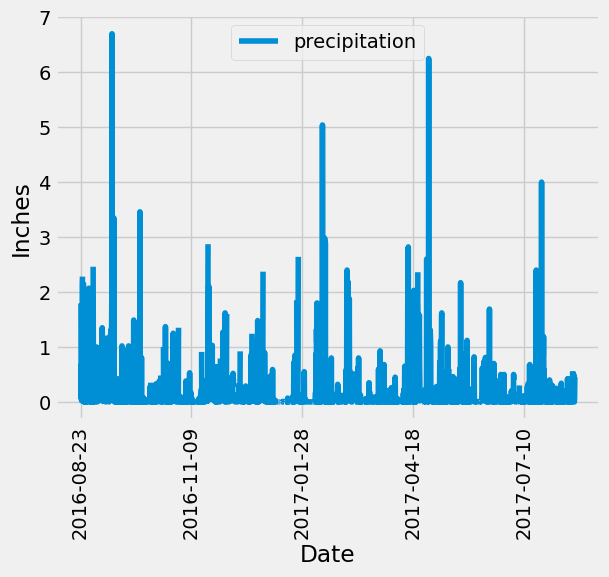

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
query_one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
# For histogram in Challenge shows one year
query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_one_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_query_results = pd.DataFrame(query_results, columns=['Date','Inches'])

# Sort the dataframe by date
df_query_results = df_query_results.sort_values("Date") 
#df_date_index = df_query_results.set_index("Date").dropna() # setting date as index & dropping multiple "NaN"s

#df_date_index
df_query_results
# Use Pandas Plotting with Matplotlib to plot the data
df_query_results.plot(x='Date', y='Inches', rot=90, figsize=(6.25,5),x_compat=True)
# f_date_index.plot(rot = 90, figsize = (8,5))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["precipitation"])

plt.show()

# NOTE TO GRADER: The labeling of the legend and x-axis tick marks are consistent with those in climate_starter.ipynb provided with this Challenge.

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_query_results.describe()

,Inches
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# which station id has the greatest number of observations
greatest_number_of_observations = active_stations[0][0]
print(f'The station id with the greatest number of observations is {greatest_number_of_observations}.')


The station id with the greatest number of observations is USC00519281.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# tobs = temperatures
most_active_station_stats = session.query(Measurement.station,\
                                    func.min(Measurement.tobs),\
                                    func.max(Measurement.tobs),\
                                    func.avg(Measurement.tobs).\
                                    filter(Measurement.station == greatest_number_of_observations))


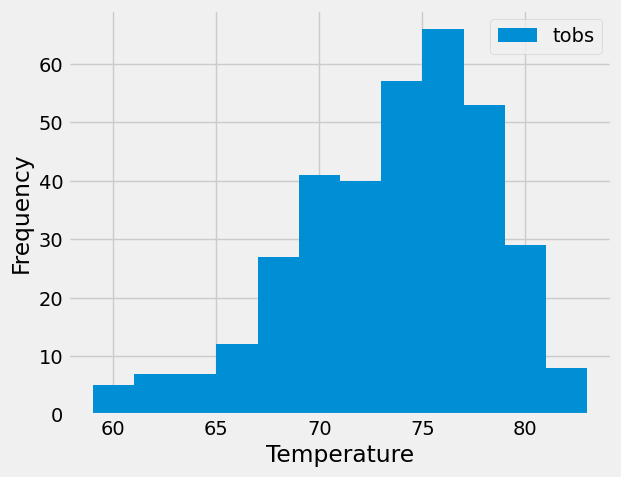

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_results = session.query(Measurement.station, Measurement.tobs)\
            .filter(Measurement.date >= query_one_year)\
            .filter(Measurement.station == greatest_number_of_observations)

df_most_active = pd.DataFrame(query_results)

df_most_active.plot.hist(figsize = (6.25,5), bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc = "upper right")

plt.show()

# Close Session

In [19]:
# Close Session
session.close()